In [1]:
from os import path
from scipy.misc import imread
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re
from os.path import join
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import tree
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
#from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [5]:
mypath="/Users/chenlaishi/Documents/GitHub/Stat_628_2/data"
file="random100000w.csv"
data=pd.read_csv(join(mypath,file))
data=data.dropna()
stars=data['stars'].values.tolist()
texts=data['text'].values.tolist()

In [6]:
from collections import Counter
def balance_classes(x, y):
    freqs = Counter(y)
    max_allowable = freqs.most_common()[-1][1]
    num_added = {clss: 0 for clss in freqs.keys()}
    new_y = []
    new_x = []
    new_i = []
    for i, yy in enumerate(y):
        if num_added[yy] < max_allowable:
            new_i.append(i)
            new_y.append(yy)
            new_x.append(x[i])
            num_added[yy] += 1
    return new_x, new_y, new_i

balanced_x, balanced_y, balanced_i = balance_classes(texts, stars)

In [7]:
##LDA
textslist=balanced_x
texts=[[textslist[i]] for i in range(len(textslist))]
from gensim import corpora, models, similarities 
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
%time corpus = [dictionary.doc2bow(text) for text in texts]
%time lda = models.LdaModel(corpus, num_topics=10, id2word=dictionary, update_every=5, chunksize=10000, passes=100)
Xlda=np.array([lda.get_document_topics(x) for x in corpus])
Xlda=np.squeeze(Xlda[:,:,1:2], axis=(2,)).astype(np.float)

CPU times: user 192 ms, sys: 3.05 ms, total: 195 ms
Wall time: 196 ms
CPU times: user 17min 55s, sys: 7.19 s, total: 18min 2s
Wall time: 18min 5s


In [8]:
i=np.asarray(balanced_i)
x=np.asarray(balanced_x)
y=np.asarray(balanced_y)

In [9]:
#save lda feature to csv
ii=i.reshape((i.shape[0],1))
xx=x.reshape((x.shape[0],1))
yy=y.reshape((y.shape[0],1))
balanced_lda=np.concatenate([ii,xx, Xlda,yy], axis=1)
balanced_lda.shape
df_lda = pd.DataFrame(balanced_lda)
df_lda.to_csv("balanced_lda.csv")

In [18]:
#vectorize
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(x)
#X_counts = count_vect.fit_transform(data['text']).toarray().ravel()                                                  
words = np.array(count_vect.get_feature_names()) 
# normalize???                                                                                                                                             
#X_counts = X_counts / float(X_counts.max())
#wordfreq=dict(zip(words, X_counts))
#tfidf
tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X_counts)
print(X.shape)

(48835, 63899)


In [24]:
##SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)
svd.fit(X)  
Xsvd=svd.transform(X)
print(Xsvd.shape)

(48835, 10)


In [25]:
#train
X_combo=np.concatenate([Xlda,Xsvd], axis=1)
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X_combo, y)
mse=0
for train_index, test_index in skf.split(X_combo, y):
    X_train, X_test = X_combo[train_index], X_combo[test_index]
    y_train, y_test = y[train_index], y[test_index]
    clf = BaggingClassifier(svm.LinearSVC())
    clf.fit(X_train, y_train)
    preds=clf.predict(X_test)
    mse+=mean_squared_error(y_test, preds)   
mse=mse/5
print(mse)

1.9148773768


In [20]:
# #Tree-based feature selection
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.feature_selection import SelectFromModel
# clf = ExtraTreesClassifier()
# clf = clf.fit(X, y)
# importances=clf.feature_importances_  
# model = SelectFromModel(clf, prefit=True)
# Xtree=model.transform(X)
# print(Xtree.shape)
# #important_features = pd.Series(data=importances,index=words)
# #important_features=pd.DataFrame({'word':words,'importance':importances})
# #important_features.sort_values(ascending=False,inplace=True)

(48835, 2284)


In [16]:
# #keep only adjective
# adj_x=[]
# for line in balanced_x:
#     tokens = nltk.word_tokenize(line)
#     tags = nltk.pos_tag(tokens)
#     adj=[word for word,pos in tags if (pos == 'JJ' or pos == 'JJR' or pos == 'JJS')]
#     adj_x.append(' '.join(str(e) for e in adj))

In [5]:
# #chisq
# from sklearn.feature_selection import SelectKBest, chi2

# X_train, X_test=X[:50000],X[50001:]
# y_train, y_test=y[:50000],y[50001:]
# ch2_result = []
# for n in np.arange(100,500,20):
#     ch2 = SelectKBest(chi2, k=n)
#     x_train_chi2_selected = ch2.fit_transform(X_train, y_train)
#     x_validation_chi2_selected = ch2.transform(X_test)
#     clf = RandomForestClassifier(n_estimators=20, random_state=0)
#     clf.fit(x_train_chi2_selected, y_train)
#     #score = clf.score(x_validation_chi2_selected, y_test)
#     predsRF=clf.predict(x_validation_chi2_selected)
#     mseRF=mean_squared_error(y_test, predsRF)
    
#     ch2_result.append(precision)
# ch2_result[:10]    

IndentationError: unexpected indent (<ipython-input-5-68159cb61da0>, line 7)

In [26]:
# #VarianceThreshold
# from sklearn.feature_selection import VarianceThreshold
# sel = VarianceThreshold(threshold=0.001)
# Xsel=sel.fit_transform(X)
# print(Xsel.shape)

(48835, 53)


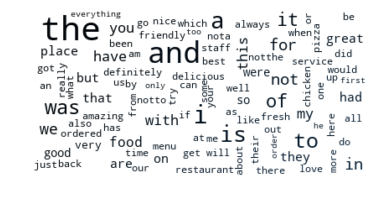

In [16]:
# #wordcloud
# dist1=pd.read_csv("/Users/chenlaishi/Documents/GitHub/Stat_628_2/data/dist5_ori.csv")
# w=dist1['word'].values
# wcounts=dist1['nnn'].values
# wordfreq=dict(zip(w, wcounts))

# backimg = np.array(Image.open("/Users/chenlaishi/Documents/stat628/module2/backimg.jpg"))
# image_colors = ImageColorGenerator(backimg)
# wc = WordCloud(background_color="white", max_words=100,max_font_size=40, random_state=42)
# wc.generate_from_frequencies(wordfreq)
# plt.imshow(wc.recolor(color_func=image_colors),interpolation="bilinear")
# plt.axis("off")
# plt.savefig("dist5_ori.png",dpi=500)

In [54]:
# #sparse to array
# #Xsel=Xsel.toarray()
# X=X.toarray()
# #NN
# import tensorflow as tf
# learning_rate = 0.0001
# n_hidden = 200
# num_input = X.shape[1]
# num_classes = 5
# num_steps = 1000
# batch_size = 200

# input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={'feat': X}, y=y-1,
#     batch_size=batch_size, num_epochs=None, shuffle=True)

# def neural_net(x_dict):
#     x = x_dict['feat']
#     layer = tf.layers.dense(x, n_hidden)
#     out_layer = tf.layers.dense(layer, num_classes)
#     return out_layer
# def model_fn(features, labels, mode):
    
#     logits = neural_net(features)
#     pred_classes = tf.argmax(logits, axis=1)
#     if mode == tf.estimator.ModeKeys.PREDICT:
#         return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 

#     loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
#         logits=logits, labels=tf.cast(labels, dtype=tf.int32)))
#     optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#     train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
#     acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    
#     # TF Estimators requires to return a EstimatorSpec, that specify
#     # the different ops for training, evaluating, ...
#     eval_metric_ops = {
#       "rmse": tf.metrics.root_mean_squared_error(
#           pred_classes,tf.cast(labels, tf.int64))
#   }


#     return tf.estimator.EstimatorSpec(
#       mode=mode,
#       loss=loss_op,
#       train_op=train_op,
#       eval_metric_ops=eval_metric_ops)
# # Build the Estimator
# model = tf.estimator.Estimator(model_fn)

# # Train the Model
# model.train(input_fn, steps=num_steps)
# # Define the input function for evaluating
# input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={'feat': X[:1000]}, y=y[:1000]-1,
#     batch_size=batch_size, shuffle=False)
# # Use the Estimator 'evaluate' method
# model.evaluate(input_fn)


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/1l/gmywf_r91sl1t_k07dlwnf7w0000gn/T/tmpulxrn8od', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13be48860>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/1l/gmywf_r91sl1t_k07dlwnf7w0000gn/T/tmpulxrn8od/model.ckpt.
INFO:tensorflow:loss = 1.60899404899, step = 1
INFO:tensorflow:global_step/sec: 0.843529
INFO:tensorflow:loss = 1.60772948939, step = 101 (118.558 sec)
INFO:tensorflow:global_step/sec: 0.833757
INFO:tensorflow:loss = 

{'global_step': 1000, 'loss': 1.5896935, 'rmse': 1.7896928}